In [293]:
import pandas as pd
import numpy as np
import pickle
import glob
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
                            confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

## Загрузка данных из файлов

In [189]:
directory_path = 'data\*.txt'
file_paths = glob.glob(directory_path)

df = pd.DataFrame()
for file_path in file_paths:
    print(file_path)
    if file_path == 'data\lambda.txt':
        temp = pd.read_csv(file_path, delimiter='\t', header=None).values.flatten()
        temp = pd.DataFrame(np.array([[i]*6 for i in temp]).flatten())
    else:
        temp = pd.DataFrame(pd.read_csv(file_path, delimiter='\t', header=None).values.flatten())
    df = pd.concat([df, temp], axis=1)
df.columns = ['b1', 'bsr', 'h', 'K', 'l', 'l12', 'lambda', 'ugol']
df = df[['b1', 'bsr', 'h', 'l', 'l12', 'ugol', 'K', 'lambda']]
df = df.dropna(axis=0)

data\b1.txt
data\bsr.txt
data\h.txt
data\K.txt
data\l.txt
data\l12.txt
data\lambda.txt
data\ugol.txt


In [190]:
df

,b1,bsr,h,l,l12,ugol,K,lambda
0,4.486358,3.905364,0.390536,15.491933,7.745967,9.0,14.71,4
1,4.696149,3.931302,0.393130,15.491933,7.745967,12.0,14.63,4
2,4.910666,3.965658,0.396566,15.491933,7.745967,15.0,14.06,4
3,5.131293,4.009256,0.400926,15.491933,7.745967,18.0,14.55,4
4,5.359562,4.063183,0.406318,15.491933,7.745967,21.0,14.23,4
5,4.149875,3.509355,0.350935,17.320508,8.660254,9.0,16.10,4
6,4.384429,3.545604,0.354560,17.320508,8.660254,12.0,15.77,5
7,4.624266,3.593619,0.359362,17.320508,8.660254,15.0,15.80,5
8,4.870934,3.654548,0.365455,17.320508,8.660254,18.0,14.94,5
9,5.126148,3.729913,0.372991,17.320508,8.660254,21.0,15.09,5


In [191]:
df.shape

(30, 8)

## Генерация данных

In [192]:
n_samples = 1000
bootstrap_samples = df.sample(n=n_samples, replace=True)

df_exp = pd.concat([df, bootstrap_samples], ignore_index=True)

In [57]:
df_exp

,b1,bsr,h,K,l,l12,lambda,ugol
0,4.486358,3.905364,0.390536,14.71,15.491933,7.745967,4,9.0
1,4.696149,3.931302,0.393130,14.63,15.491933,7.745967,4,12.0
2,4.910666,3.965658,0.396566,14.06,15.491933,7.745967,4,15.0
3,5.131293,4.009256,0.400926,14.55,15.491933,7.745967,4,18.0
4,5.359562,4.063183,0.406318,14.23,15.491933,7.745967,4,21.0
...,...,...,...,...,...,...,...,...
1025,3.502050,2.691273,0.269127,18.71,23.237900,11.618950,8,9.0
1026,5.131293,4.009256,0.400926,14.55,15.491933,7.745967,4,18.0
1027,4.433174,3.332532,0.333253,16.16,18.973666,9.486833,6,15.0
1028,4.982958,3.511696,0.351170,15.33,18.973666,9.486833,6,21.0


In [58]:
df_exp.shape

(1030, 8)

In [217]:
df_exp.to_csv('data_expanded.csv', index=False, header=True, sep=';')

## Преобразование данных

In [228]:
train = df_exp.drop(['K', 'lambda'], axis=1).values
y = df_exp[['K', 'lambda']].values

In [236]:
encoder = LabelEncoder()
y[:, 1] = encoder.fit_transform(y[:, 1])

with open('models\labelencoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [237]:
train.shape, y.shape

((1030, 6), (1030, 2))

## Разбиение на подвыборки и стандартизация

In [238]:
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)

In [239]:
x_train.shape, x_test.shape

((824, 6), (206, 6))

In [245]:
scaler = StandardScaler()
scaler.fit(x_train)
with open('models\scaler_x.pkl', 'wb') as f:
    pickle.dump(scaler, f)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [246]:
y_reg_train = y_train[:, 0]
y_reg_test = y_test[:, 0]

y_class_train = y_train[:, 1]
y_class_test = y_test[:, 1]

In [247]:
scaler = StandardScaler()
scaler.fit(y_reg_train.reshape(-1, 1))
with open('models\scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler, f)

y_reg_train = scaler.transform(y_reg_train.reshape(-1, 1))
y_reg_test = scaler.transform(y_reg_test.reshape(-1, 1))

## Обучение нейросети для задачи регресии (параметр K)

In [263]:
model = tf.keras.Sequential()
model.add(layers.Reshape((6, 1), input_shape=(6,)))
model.add(layers.Conv1D(64, 4, activation='relu'))
model.add(layers.Conv1D(32, 2, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', input_shape=(6,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_21 (Reshape)        (None, 6, 1)              0         
                                                                 
 conv1d_40 (Conv1D)          (None, 3, 64)             320       
                                                                 
 conv1d_41 (Conv1D)          (None, 2, 32)             4128      
                                                                 
 flatten_23 (Flatten)        (None, 64)                0         
                                                                 
 dense_154 (Dense)           (None, 128)               8320      
                                                                 
 dense_155 (Dense)           (None, 64)                8256      
                                                                 
 dense_156 (Dense)           (None, 32)              

In [264]:
history = model.fit(x_train, y_reg_train, validation_split=0.2, batch_size=32, epochs=100)

Epoch 1/100
21/21 [==============================] - 1s 9ms/step - loss: 0.4242 - val_loss: 0.0667
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0256
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0251 - val_loss: 0.0238
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0211 - val_loss: 0.0199
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0208 - val_loss: 0.0201
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0214
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0173 - val_loss: 0.0215
Epoch 8/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0173 - val_loss: 0.0155
Epoch 9/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0145 - val_loss: 0.0134
Epoch 10/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0141 - val_loss: 0.0129
Epoch 11/

Epoch 79/100
21/21 [==============================] - 0s 2ms/step - loss: 1.4513e-09 - val_loss: 4.9662e-10
Epoch 80/100
21/21 [==============================] - 0s 2ms/step - loss: 3.1692e-10 - val_loss: 9.4330e-10
Epoch 81/100
21/21 [==============================] - 0s 3ms/step - loss: 5.0016e-10 - val_loss: 1.8980e-10
Epoch 82/100
21/21 [==============================] - 0s 2ms/step - loss: 1.1311e-09 - val_loss: 9.6221e-10
Epoch 83/100
21/21 [==============================] - 0s 3ms/step - loss: 1.5928e-09 - val_loss: 1.4257e-09
Epoch 84/100
21/21 [==============================] - 0s 3ms/step - loss: 1.1597e-09 - val_loss: 1.0154e-09
Epoch 85/100
21/21 [==============================] - 0s 2ms/step - loss: 8.7781e-10 - val_loss: 5.5480e-10
Epoch 86/100
21/21 [==============================] - 0s 3ms/step - loss: 4.7324e-10 - val_loss: 4.0668e-10
Epoch 87/100
21/21 [==============================] - 0s 2ms/step - loss: 4.4630e-10 - val_loss: 7.1651e-10
Epoch 88/100
21/21 [========

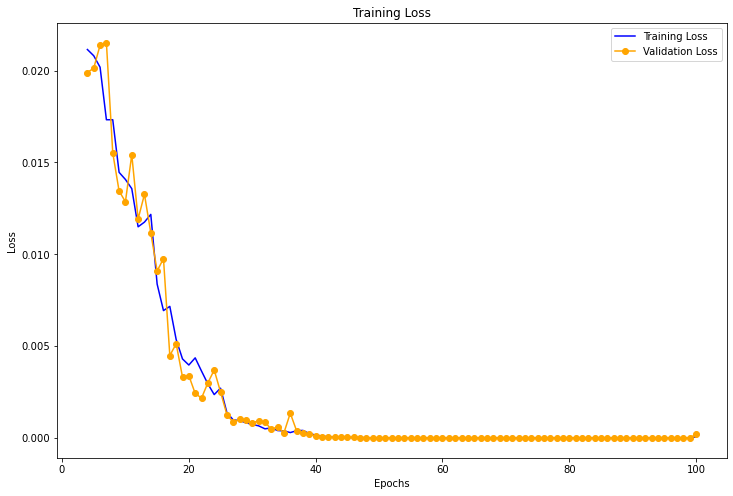

In [265]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(4, len(loss) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, loss[3:], 'b-', label='Training Loss')
plt.plot(epochs, val_loss[3:], 'o-', label='Validation Loss', color='orange')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [266]:
predictions = model.predict(x_test)

7/7 [==============================] - 0s 3ms/step


In [267]:
mse = mean_squared_error(y_reg_test, predictions)
mae = mean_absolute_error(y_reg_test, predictions)
r2 = r2_score(y_reg_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 0.00013137072561109184
Mean Absolute Error (MAE): 0.008821214641496114
R-squared (R2) Score: 0.9998388543338513


In [268]:
model.save('models\k.h5')

## Обучение нейросети для задачи классификации (параметр lambda)

In [288]:
model = tf.keras.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(6,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [289]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_173 (Dense)           (None, 64)                448       
                                                                 
 dense_174 (Dense)           (None, 32)                2080      
                                                                 
 dense_175 (Dense)           (None, 5)                 165       
                                                                 
Total params: 2,693
Trainable params: 2,693
Non-trainable params: 0
_________________________________________________________________


In [290]:
history = model.fit(x_train, y_class_train, validation_split=0.2, batch_size=100, epochs=50)

Epoch 1/50
7/7 [==============================] - 0s 25ms/step - loss: 1.4315 - accuracy: 0.3399 - val_loss: 1.3265 - val_accuracy: 0.4485
Epoch 2/50
7/7 [==============================] - 0s 6ms/step - loss: 1.3217 - accuracy: 0.4021 - val_loss: 1.2303 - val_accuracy: 0.4788
Epoch 3/50
7/7 [==============================] - 0s 3ms/step - loss: 1.2416 - accuracy: 0.4613 - val_loss: 1.1630 - val_accuracy: 0.5212
Epoch 4/50
7/7 [==============================] - 0s 3ms/step - loss: 1.1743 - accuracy: 0.4856 - val_loss: 1.1048 - val_accuracy: 0.5212
Epoch 5/50
7/7 [==============================] - 0s 6ms/step - loss: 1.1112 - accuracy: 0.4856 - val_loss: 1.0529 - val_accuracy: 0.5212
Epoch 6/50
7/7 [==============================] - 0s 5ms/step - loss: 1.0529 - accuracy: 0.4886 - val_loss: 1.0076 - val_accuracy: 0.5273
Epoch 7/50
7/7 [==============================] - 0s 3ms/step - loss: 1.0013 - accuracy: 0.5235 - val_loss: 0.9640 - val_accuracy: 0.5273
Epoch 8/50
7/7 [=================

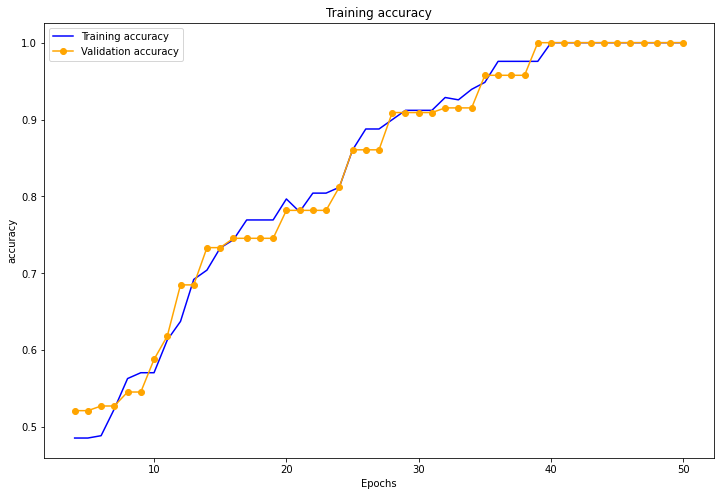

In [292]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(4, len(accuracy) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, accuracy[3:], 'b-', label='Training accuracy')
plt.plot(epochs, val_accuracy[3:], 'o-', label='Validation accuracy', color='orange')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [306]:
pred_prob = model.predict(x_test)
y_pred = np.argmax(pred_prob, axis=1)

7/7 [==============================] - 0s 3ms/step


In [313]:
accuracy = accuracy_score(y_class_test, y_pred)
precision = precision_score(y_class_test, y_pred, average='macro')
recall = recall_score(y_class_test, y_pred, average='macro')
f1 = f1_score(y_class_test, y_pred, average='macro')
confusion_mat = confusion_matrix(y_class_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[40  0  0  0  0]
 [ 0 38  0  0  0]
 [ 0  0 42  0  0]
 [ 0  0  0 42  0]
 [ 0  0  0  0 44]]


In [314]:
model.save('models\lambda.h5')